# Restraints ML

In [1]:
import sys
sys.path.append("../")
import os
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # suppress rdkit output

## Load data

In [2]:
data_dir = "../data/cod/random_sample01/"
files = [os.path.join(data_dir,file) for file in os.listdir(data_dir)]

N_max = 500
rdmols = []
for i,file in enumerate(files):
  if len(rdmols)<N_max:
    rdmol = Chem.MolFromMol2File(file,removeHs=False)
    if rdmol is not None:
      rdmols.append(rdmol)

## Fragment

In [3]:
from phenixml.fragmentation.fragmenter_restraints import AngleFragmenter

angle_fragmenter = AngleFragmenter(exclude_symbols=["H"])
frags = []
for rdmol in rdmols:
  fs = angle_fragmenter.fragment(rdmol)
  if fs is not None and len(fs)>0:
    frags+=fs
print("Framents:",len(frags))

Framents: 22152


In [4]:
# explore fragments
frag = frags[200]

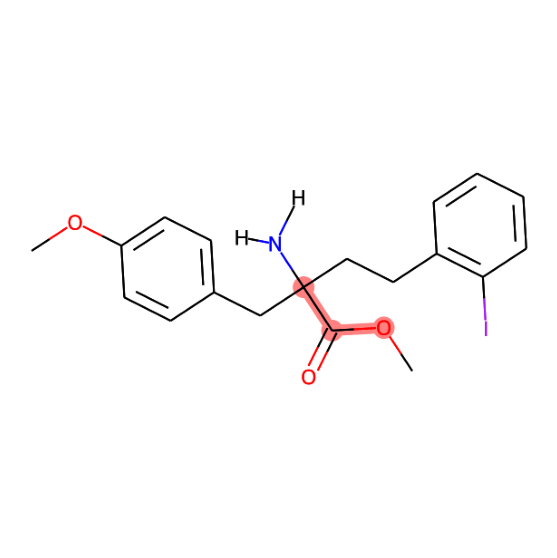

In [5]:
frag.show(hide_H=True)

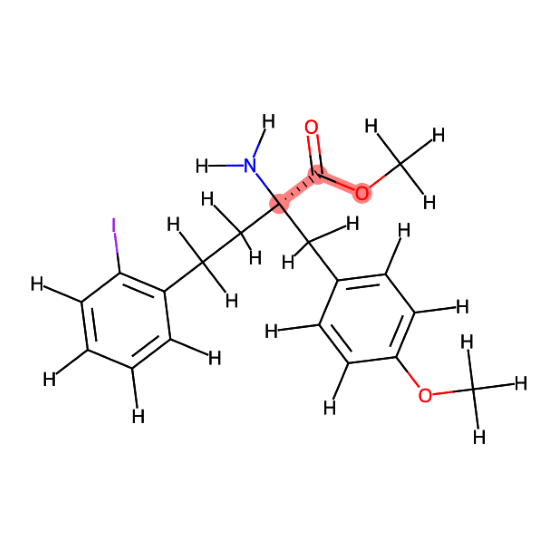

In [6]:
frag.show(hide_H=False)

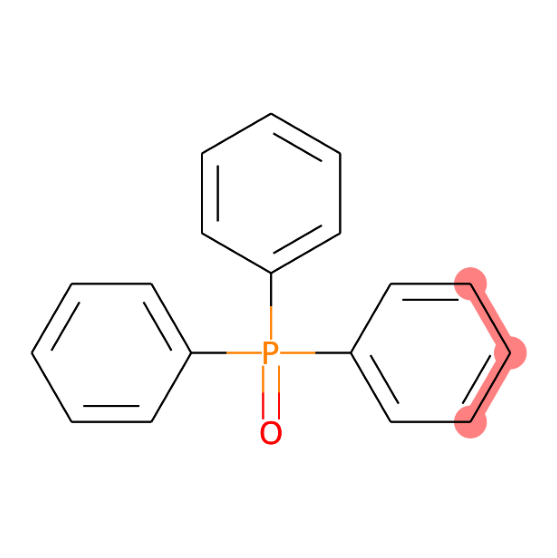

In [7]:
frag = frags[350]
frag.show()

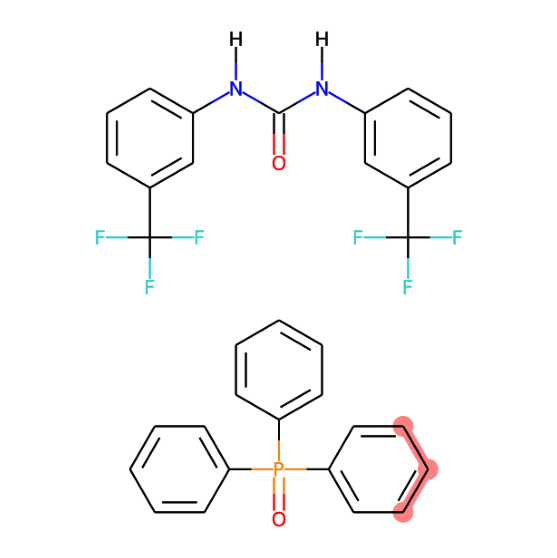

In [8]:
frag.show(only_connected=False) # optionall show other molecules in environment

## Labelize

In [9]:
import numpy as np
from phenixml.labelizers.bond_angles_lengths import AngleFragLabeler

In [10]:
labeler = AngleFragLabeler(degrees=True)

In [11]:
labels = np.array([labeler.labelize(frag) for frag in frags])

<AxesSubplot:ylabel='Count'>

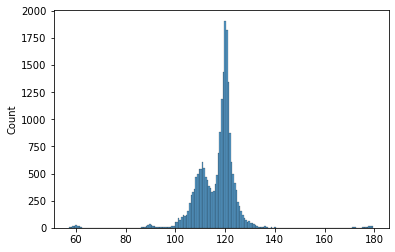

In [12]:
import seaborn as sns
sns.histplot(labels)

## Featurize

In [13]:
# Use a simple SMILES like token as the features
from phenixml.featurizers.bond_angle_tokenizer import AngleTokenizer
angle_tokenizer = AngleTokenizer(ignore_bond_type=True)
tokens = [angle_tokenizer.featurize(frag) for frag in frags]
print(tokens[:4])

[['C', 'C', 'C'], ['C', 'C', 'C'], ['C', 'C', 'O'], ['C', 'C', 'O']]


In [14]:
# encode to numeric vector
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(tokens)
features = encoder.transform(tokens)
print(features.shape)

(22152, 25)


## Regression

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [16]:
# Train/test split
X,y = features,labels
inds = np.arange(len(frags))
train,test = train_test_split(inds,test_size=0.2)
X_train,y_train = X[train], y[train]
X_test, y_test = X[test], y[test]
frags_train,frags_test = [frags[i] for i in train],[frags[i] for i in test]

In [17]:
%%time
model = RandomForestRegressor(n_estimators=100,n_jobs=-1)
model.fit(X_train,y_train)

CPU times: user 1.91 s, sys: 132 ms, total: 2.04 s
Wall time: 298 ms


RandomForestRegressor(n_jobs=-1)

In [18]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'Predicted')

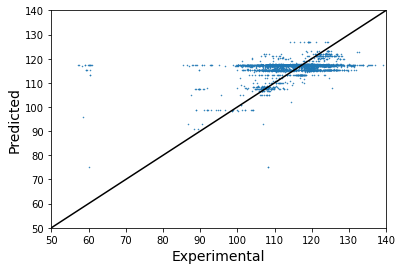

In [19]:
mode = "angle"
import pandas as pd
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [20]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 8.04060952675246


# Try with the Morgan circular fingerprint

## Featurize

In [21]:
from phenixml.featurizers.fingerprints import MorganFeaturizer

featurizer = MorganFeaturizer(radius=2,nBits=1024)
features = np.vstack([featurizer.featurize(frag) for frag in frags])
print(features.shape)

(22152, 1024)


## Regression

In [22]:
# Train/test split
X,y = features,labels
X_train,y_train = X[train], y[train]
X_test, y_test = X[test], y[test]
frags_train,frags_test = [frags[i] for i in train],[frags[i] for i in test]

In [23]:
%%time
model = RandomForestRegressor(n_estimators=100,n_jobs=-1)
model.fit(X_train,y_train)

CPU times: user 14min 48s, sys: 887 ms, total: 14min 49s
Wall time: 14.9 s


RandomForestRegressor(n_jobs=-1)

In [24]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'Predicted')

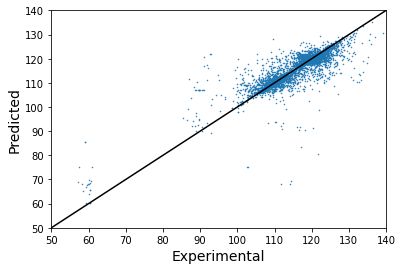

In [25]:
mode = "angle"
import pandas as pd
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [71]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 5.0201445052955656


# Try Regression with the ANI Featurizer

## Featurize

In [26]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [27]:
# elements and parameters

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': ["O","C","H","N","P","S","Cl","B","F","I","Br"]}

In [28]:
features = []
for frag in frags:
  feature = ANIFeaturizer.from_bond_angle_frags([frag],params).featurize()
  features.append(feature)
features = np.vstack(features)

## Regression

In [29]:
X,y = features,labels
X_train,y_train = X[train], y[train]
X_test, y_test = X[test], y[test]
frags_train,frags_test = [frags[i] for i in train],[frags[i] for i in test]

In [30]:
%%time
model = RandomForestRegressor(n_estimators=100,n_jobs=-1)
model.fit(X_train,y_train)

CPU times: user 7min 11s, sys: 1.86 s, total: 7min 13s
Wall time: 6.14 s


RandomForestRegressor(n_jobs=-1)

In [31]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'Predicted')

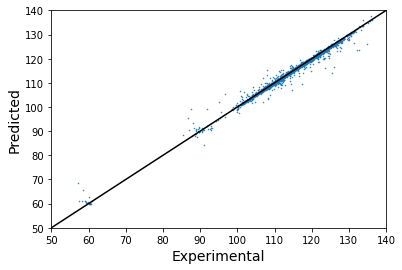

In [32]:
mode = "angle"
import pandas as pd
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [33]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 0.8094279735149928
